# Predictive maintenance of a CNC milling machine

## Predictive maintenance

To be continued...

## Experimental set-up

<img src="figures/exp_setup.png" alt="experimental setup" width="600"/>

*Experimental set-up (Source: [ Fuzzy Neural Network Modelling for Tool Wear Estimation in Dry Milling Operation ](https://papers.phmsociety.org/index.php/phmconf/article/view/1403))*

#### Cutter or milling bit

The tool doing the cutting is called a milling bit and it can have multiple flutes i.e sharp slots that corkscrew upwards along the length of the milling bit.

<img src="figures/flutes.png" alt="flutes_explanation" width="450"/>

*Visualization of flutes (Source: [https://www.cs.cmu.edu/~rapidproto/students.03/zdb/project2/CNCflutes.htm](https://www.cs.cmu.edu/~rapidproto/students.03/zdb/project2/CNCflutes.htm))*

#### Dynamometer

The dynamometer is set on the machine table hlding the metal workpiece, allowing it to measure forces applied to the workpiece in three dimensions.

<img src="figures/dynamometer.jpg" alt="dynamomter" width="400"/>

*Dynamometer set-up (Source: [Cutting forces during longitudinal turning process of Ti-6Al-4V ELI alloy. Theoretical and experimental values](https://www.researchgate.net/publication/329478165_Cutting_forces_during_longitudinal_turning_process_of_Ti-6Al-4V_ELI_alloy_Theoretical_and_experimental_values))*

#### Accelerometer

Accelerometers are mounted on the workpiece itself and measure the vibrations felt by the workpiece.

<img src="figures/accelerometer.jpg" alt="dynamomter" width="400"/>

*Accelerometer set-up (Source: [Guidelines for Mounting Test Accelerometers](https://www.pcb.com/resources/technical-information/mounting))*

#### Acoustic Emission (AE) sensor

The acoustic emission sensor is mounted on the workpiece and detects elastic waves that go through the workpiece in events like friction, cracks and deformation.

<img src="figures/ae_sensor.png" alt="dynamomter" width="400"/>

*Acoustic emission sensor set-up (Source: [Identification of tool wear using acoustic emission signal and machine learning methods](https://www.sciencedirect.com/science/article/pii/S0141635921001884))*

## Dataset description

The raw downloaded data is placed in the `data/raw/` directory and unziped. The data has an internal directory structure:

```
├── c1 
│   ├── c1
│   │   ├── c_1_001.csv
│   │   ├── c_1_002.csv
│   │   ├── ...
│   ├── c1_wear.csv
├── c2 
│   ├── c2
│   │   ├── c_2_001.csv
│   │   ├── c_2_002.csv
│   │   ├── ...
├── c3 
│   ├── c3
│   │   ├── c_3_001.csv
│   │   ├── c_3_002.csv
│   │   ├── ...
├── c4 
│   ├── c4
│   │   ├── c_4_001.csv
│   │   ├── c_4_002.csv
│   │   ├── ...
│   ├── c4_wear.csv
├── c5 
│   ├── c5
│   │   ├── c_5_001.csv
│   │   ├── c_5_002.csv
│   │   ├── ...
├── c6 
│   ├── c6
│   │   ├── c_6_001.csv
│   │   ├── c_6_002.csv
│   │   ├── ...
│   ├── c6_wear.csv

```



Each `c$number/c$number` directory corresponds to a test of 315 cuts measured by the monitoring system mounted on the CNC milling machine as it removed material off the metal piece. The data the monitoring system recorded was:

* Column 1: Force (N) in X dimension
* Column 2: Force (N) in Y dimension
* Column 3: Force (N) in Z dimension
* Column 4: Vibration (g) in X dimension
* Column 5: Vibration (g) in Y dimension
* Column 6: Vibration (g) in Z dimension
* Column 7: AE-RMS (V)

The actual wear in the flutes of the cutter in units of $10^{-3}$ mm ($\mu m$) is available for tests 1, 4 and 6 in the `c$number_wear.csv` files.

## Import and preprocessing

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Loading the data for a single cut in the first test

In [2]:
df_cut = pd.read_csv('../data/raw/c1/c1/c_1_001.csv', sep=',', header=None)

Looking for null and missing values

In [3]:
df_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127399 entries, 0 to 127398
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       127399 non-null  float64
 1   1       127399 non-null  float64
 2   2       127399 non-null  float64
 3   3       127399 non-null  float64
 4   4       127399 non-null  float64
 5   5       127399 non-null  float64
 6   6       127399 non-null  float64
dtypes: float64(7)
memory usage: 6.8 MB


Data seems to be complete because `Non-Null Count` matches the number of entries.

Taking a peek:

In [4]:
df_cut.head(10)

,0,1,2,3,4,5,6
0,0.704,-0.387,-1.084,0.018,0.031,0.027,-0.004
1,0.772,-0.573,-1.153,-0.056,-0.057,-0.058,-0.004
2,0.828,-0.673,-1.242,0.037,0.019,0.031,-0.004
3,0.866,-0.601,-1.311,-0.028,-0.027,-0.022,-0.004
4,0.910,-0.377,-1.341,-0.050,-0.049,-0.058,-0.004
5,0.896,-0.095,-1.333,0.022,0.036,0.017,-0.004
6,0.910,0.239,-1.270,-0.062,-0.038,-0.047,-0.004
7,0.900,0.614,-1.209,-0.089,-0.067,-0.070,-0.004
8,0.879,0.974,-1.137,-0.028,-0.009,0.003,-0.004
9,0.906,1.291,-1.047,-0.093,-0.082,-0.072,-0.004


## Signal visualization

According to the competition description, the data was acquired at a sampling rate $f = 50 KHz$. This means measurements were collected every $T = \frac{1}{f} = 0.02 \,ms $.  

For the sake of clarity let's create an array that holds time in miliseconds $ms$

In [39]:
n = df_cut[0].shape[0] # number of measurements
t = 0.02*np.arange(n) # time in miliseconds

### Forces

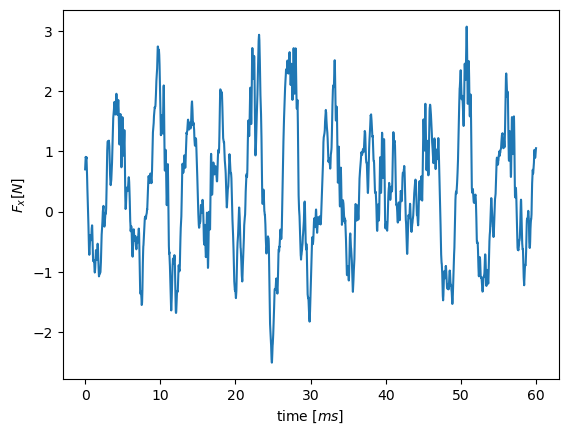

In [42]:
plt.plot(t[:3000],df_cut[0][:3000]) # plotting an slice of only 3000 out of the total number of entries
plt.xlabel(r'time [$ms$]')
plt.ylabel(r'$ F_x [N]$')
plt.show()

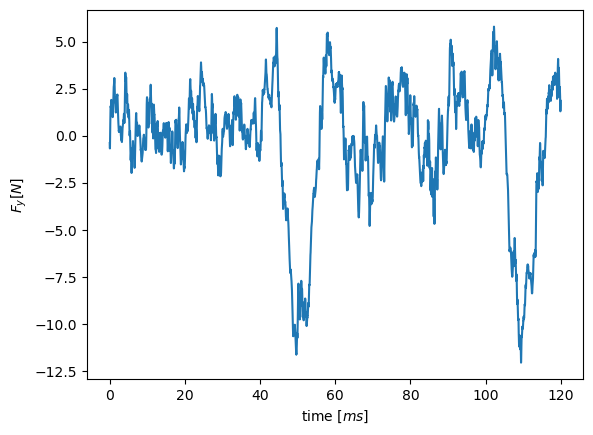

In [43]:
plt.plot(t[:6000],df_cut[1][:6000]) # plotting an slice of only 6000 out of the total number of entries
plt.xlabel(r'time [$ms$]')
plt.ylabel(r'$ F_y [N]$')
plt.show()

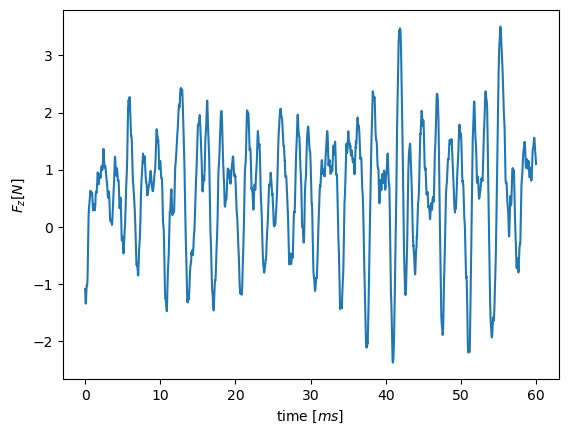

In [44]:
plt.plot(t[:3000],df_cut[2][:3000]) # plotting an slice of only 3000 out of the total number of entries
plt.xlabel(r'time [$ms$]')
plt.ylabel(r'$ F_z [N]$')
plt.show()

### Vibrations

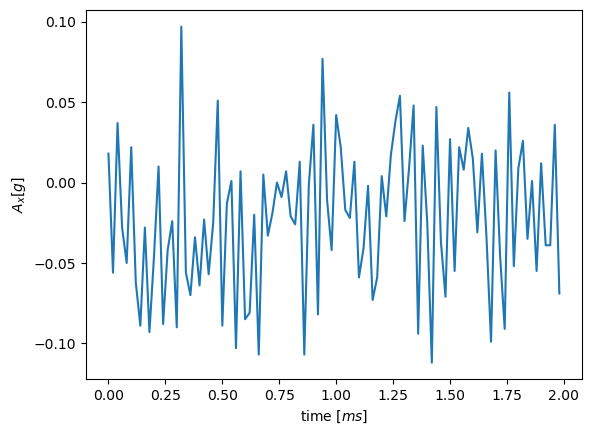

In [46]:
plt.plot(t[:100],df_cut[3][:100]) # plotting an slice of only 100 out of the total number of entries
plt.xlabel(r'time [$ms$]')
plt.ylabel(r'$ A_x [g]$')
plt.show()

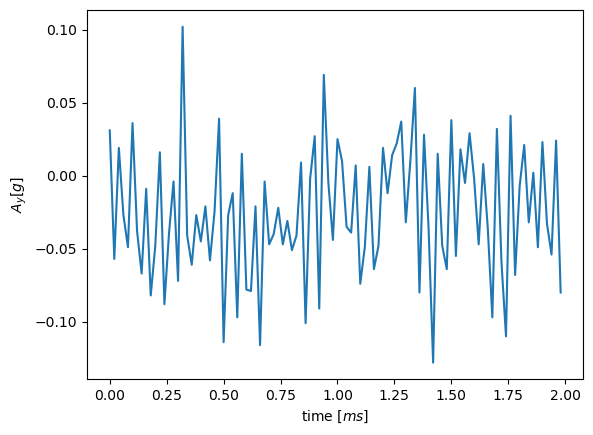

In [48]:
plt.plot(t[:100],df_cut[4][:100]) # plotting an slice of only 100 out of the total number of entries
plt.xlabel(r'time [$ms$]')
plt.ylabel(r'$ A_y [g]$')
plt.show()

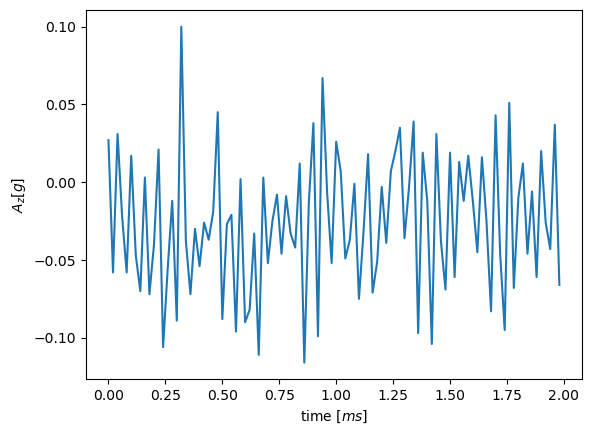

In [49]:
plt.plot(t[:100],df_cut[5][:100]) # plotting an slice of only 100 out of the total number of entries
plt.xlabel(r'time [$ms$]')
plt.ylabel(r'$ A_z [g]$')
plt.show()

### Acoustic Emission RMS

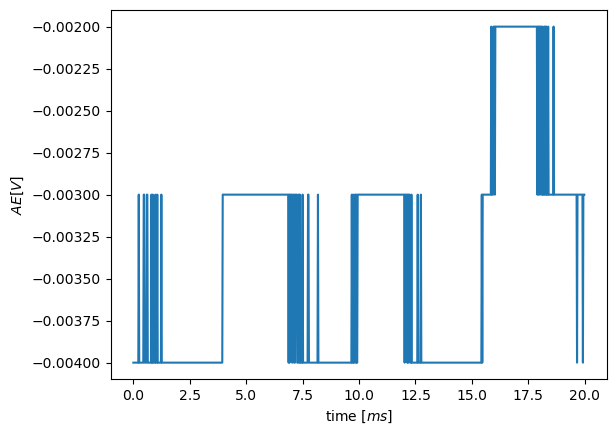

In [53]:
plt.plot(t[:1000],df_cut[6][:1000]) # plotting an slice of only 1000 out of the total number of entries
plt.xlabel(r'time [$ms$]')
plt.ylabel(r'$ AE [V]$')
plt.show()

### Wear

Loading the wear data for the first test:

In [15]:
df_wear = pd.read_csv('../data/raw/c1/c1_wear.csv', sep=',')

Looking for null and missing values

In [16]:
df_wear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cut      315 non-null    int64  
 1   flute_1  315 non-null    float64
 2   flute_2  315 non-null    float64
 3   flute_3  315 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 10.0 KB


Data is complete

Taking a look at the numbers

In [17]:
df_wear.head(10)

,cut,flute_1,flute_2,flute_3
0,1,32.317114,48.892617,37.720825
1,2,37.914879,49.570815,37.720825
2,3,43.087910,50.302867,37.720825
3,4,47.859072,51.083652,37.849851
4,5,52.250329,51.908288,38.172665
5,6,56.282766,52.772127,38.617556
6,7,59.976616,53.670745,39.174556
7,8,63.351288,54.599939,39.834155
8,9,66.425391,55.555716,40.587292
9,10,69.216757,56.534286,41.425337


Plotting the wear as the number of cuts increases

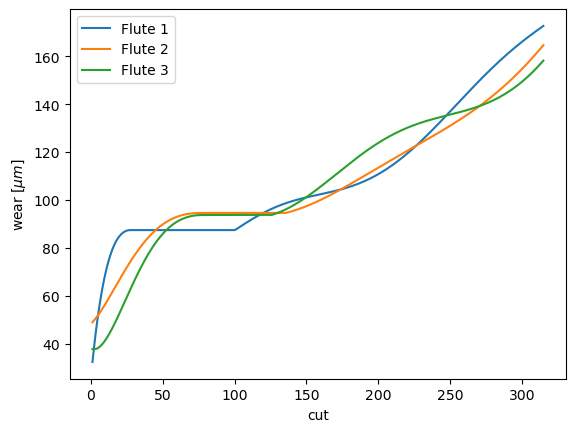

In [58]:
plt.plot(df_wear["cut"], df_wear["flute_1"], label = "Flute 1")
plt.plot(df_wear["cut"] ,df_wear["flute_2"], label = "Flute 2")
plt.plot(df_wear["cut"], df_wear["flute_3"], label = "Flute 3")
plt.xlabel(r'cut')
plt.ylabel(r'wear $[\mu m]$')
plt.legend()
plt.show()

## Frequency domain analysis

### Force

In [ ]:
from scipy import fft, signal

In [95]:
y = np.asarray(df_cut[0])

In [96]:
yf = fft.fft(y)
xf = fft.fftfreq(len(y),d=(t[1] - t[0]))

[]

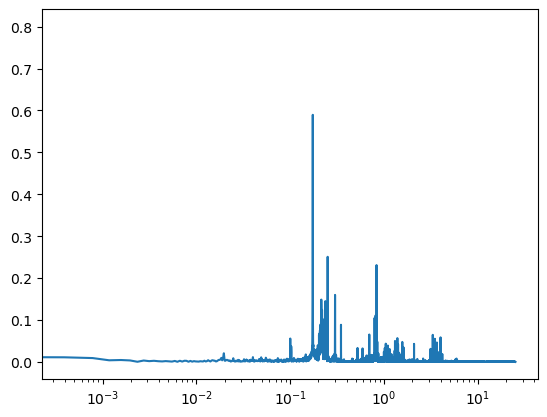

In [135]:
plt.plot(xf[0:n//2], 2.0/n * np.abs(yf[0:n//2]))
plt.xscale('log')
#plt.xlim(-20,-10)
#plt.ylim(0,0.6)
plt.plot()

### Low-pass filtering: removing high frequencies

In [105]:
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Apply the low-pass filter to the signal
def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [128]:
fs = 50000


cutoff_frequency = 500 # Cutoff frequency
order = 4  # Filter order 

# Apply high-pass filter to the signal
filtered_signal = lowpass_filter(y, cutoff_frequency, fs, order)

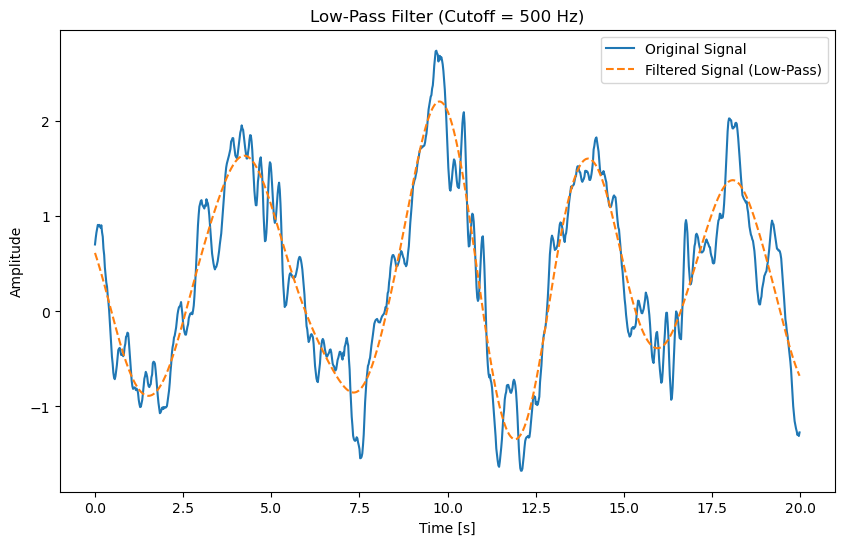

In [129]:
plt.figure(figsize=(10, 6))
plt.plot(t[:1000], y[:1000], label='Original Signal')
plt.plot(t[:1000], filtered_signal[:1000], label='Filtered Signal (Low-Pass)', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'Low-Pass Filter (Cutoff = {cutoff_frequency} Hz)')
plt.show()

In [130]:
yf_fil = fft.fft(filtered_signal)
xf = fft.fftfreq(len(y),d=(t[1] - t[0]))

[]

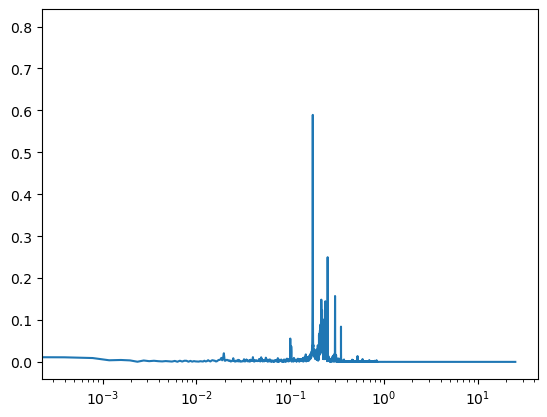

In [136]:
plt.plot(xf[0:n//2], 2.0/n * np.abs(yf_fil[0:n//2]))
plt.xscale('log')
plt.plot()

**Missing**: I don't quite understand how to make the x axis match the original units ($KHz$).